In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import tqdm
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from collections import OrderedDict
import cv2

C:\Users\chan\anaconda3\envs\proj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
  Using cached pip-23.3.1-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\chan\anaconda3\envs\proj\python.exe -m pip install --upgrade pip


In [3]:
pip install --upgrade torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [19]:
import pretrainedmodels

In [4]:
pip install --user torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [4]:
cuda_available = torch.cuda.is_available()

if cuda_available:
    # CUDA 디바이스 수 확인
    cuda_device_count = torch.cuda.device_count()
    print(f"CUDA is available with {cuda_device_count} device(s).")

    # 현재 사용 중인 CUDA 디바이스 정보 확인
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"Currently using CUDA device {current_device}: {device_name}")
else:
    print("CUDA is not available on this system.")

CUDA is not available on this system.


In [8]:
!pip install --user torch torchvision


In [5]:
train_df = pd.read_csv("whale-categorization-playground/train.csv")
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [6]:
print(f"There are {len(os.listdir('whale-categorization-playground/train'))} images in train dataset with {train_df.Id.nunique()} unique classes.")
print(f"There are {len(os.listdir('whale-categorization-playground/test'))} images in test dataset.")

There are 9850 images in train dataset with 4251 unique classes.
There are 15610 images in test dataset.


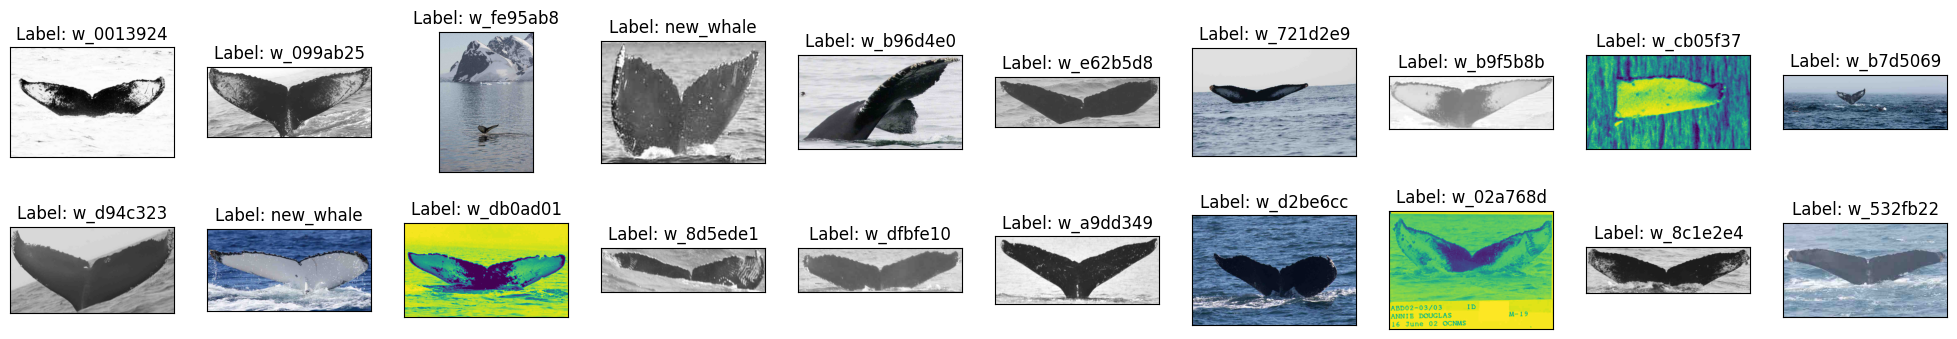

In [7]:
fig = plt.figure(figsize=(25, 4))
train_imgs = os.listdir("whale-categorization-playground/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    
    im = Image.open("whale-categorization-playground/train/" + img)
    plt.imshow(im)
    lab = train_df.loc[train_df.Image == img, 'Id'].values[0]
    ax.set_title(f'Label: {lab}')

In [8]:
train_df.Id.value_counts().head()

Id
new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
Name: count, dtype: int64

In [9]:
for i in range(1, 4):
    print(f'There are {train_df.Id.value_counts()[train_df.Id.value_counts().values==i].shape[0]} classes with {i} samples in train data.')

There are 2220 classes with 1 samples in train data.
There are 1034 classes with 2 samples in train data.
There are 492 classes with 3 samples in train data.


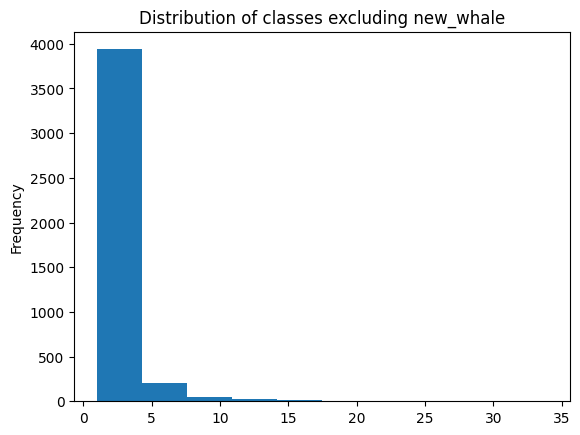

In [10]:
plt.title('Distribution of classes excluding new_whale');
train_df.Id.value_counts()[1:].plot(kind='hist');

In [11]:
np.array(im).shape

(231, 404, 3)

In [12]:
data_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
#                                       transforms.CenterCrop((112,112)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((224,224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [13]:
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [14]:
y, le = prepare_labels(train_df['Id'])

C:\Users\chan\anaconda3\envs\proj\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype='train', df=None, transform = transforms.Compose([transforms.ToTensor()]), y=None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
            
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((5005,))

        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            # so that the images will be in a correct order
            return image, label, self.image_files_list[idx]

In [16]:
train_dataset = WhaleDataset(datafolder='whale-categorization-playground/train/', datatype='train', df=train_df, transform=data_transforms, y=y)
test_set = WhaleDataset(datafolder='whale-categorization-playground/test', datatype='test', transform=data_transforms_test)

In [17]:
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('whale-categorization-playground/train')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('whale-categorization-playground/test')))))
batch_size = 512
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
# less size for test loader.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)

In [20]:
model_conv = pretrainedmodels.vgg16(num_classes=1000, pretrained='imagenet')
# model_conv.avgpool = nn.AvgPool2d((5,10))
model_conv.last_linear = nn.Linear(model_conv.last_linear.in_features, 4251)
print(model_conv)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

C:\Users\chan\anaconda3\envs\proj\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chan\anaconda3\envs\proj\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxP

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:

from sklearn.metrics import average_precision_score
n_epochs = 30
model_conv=model_conv.to(device)
for epoch in range(1, n_epochs + 1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    y_true = []
    y_scores = []
    exp_lr_scheduler.step()

    for batch_i, (data, target) in enumerate(tqdm.tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        # Collect predictions and true labels for mAP calculation
        
        y_true.extend(target.to(device).numpy())
        y_scores.extend(output.to(device).detach().numpy())

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

    # Calculate mAP
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Assuming y_scores contain the raw scores from your model
    # You might need to adjust this depending on your specific output format

    mAP = average_precision_score(y_true, y_scores, average='micro')
    print(f'Epoch {epoch}, train mAP: {mAP:.4f}')

C:\Users\chan\anaconda3\envs\proj\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Tue Nov 28 16:43:46 2023 Epoch: 1


100%|██████████| 20/20 [1:23:29<00:00, 250.48s/it]


Epoch 1, train loss: 1733948547.0855
Epoch 1, train mAP: 0.0009
Tue Nov 28 18:07:31 2023 Epoch: 2


100%|██████████| 20/20 [1:16:58<00:00, 230.94s/it]


Epoch 2, train loss: 525.7287
Epoch 2, train mAP: 0.0003
Tue Nov 28 19:24:44 2023 Epoch: 3


100%|██████████| 20/20 [1:15:58<00:00, 227.90s/it]


Epoch 3, train loss: 20.1981
Epoch 3, train mAP: 0.0005
Tue Nov 28 20:40:56 2023 Epoch: 4


100%|██████████| 20/20 [1:26:18<00:00, 258.92s/it]


Epoch 4, train loss: 10.8732
Epoch 4, train mAP: 0.0005
Tue Nov 28 22:07:28 2023 Epoch: 5


100%|██████████| 20/20 [1:18:11<00:00, 234.58s/it]


Epoch 5, train loss: 9.5459
Epoch 5, train mAP: 0.0005
Tue Nov 28 23:25:53 2023 Epoch: 6


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# model_conv=model_conv.cuda()
# n_epochs = 10
# for epoch in range(1, n_epochs+1):
#     print(time.ctime(), 'Epoch:', epoch)

#     train_loss = []
#     exp_lr_scheduler.step()

#     for batch_i, (data, target) in enumerate(tqdm.tqdm(train_loader)):
#         data, target = data.cuda(), target.cuda()

#         optimizer.zero_grad()
#         output = model_conv(data)
#         loss = criterion(output, target.float())
#         train_loss.append(loss.item())

#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')


In [ ]:


# model_conv = model_conv.to(device)
# n_epochs = 10

# for epoch in range(1, n_epochs + 1):
#     print(time.ctime(), 'Epoch:', epoch)

#     train_loss = []
#     y_true = []
#     y_scores = []

#     model_conv.train()
#     exp_lr_scheduler.step()

#     for batch_i, (data, target) in enumerate(tqdm.tqdm(train_loader)):
#         data, target = data.to(device), target.to(device)

#         optimizer.zero_grad()
#         output = model_conv(data)
#         loss = criterion(output, target.float())
#         train_loss.append(loss.item())

#         loss.backward()
#         optimizer.step()

#         # Collect predictions and true labels for MAP@5 calculation
#         y_true.extend(target.cpu().numpy())
#         y_scores.extend(output.cpu().detach().numpy())

#     print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

#     # Calculate MAP@5
#     y_true = np.array(y_true)
#     y_scores = np.array(y_scores)

# # Reshape y_scores to have shape (number of samples, number of classes)
# # If your model outputs probabilities, you might need to use [:, 1] for positive class scores
#     y_scores = y_scores.reshape(-1, 9850)  # 4251은 클래스 수로 바꿔주어야 합니다.

# # Calculate MAP@5
#     k = 5
#     indices = np.argsort(y_scores, axis=1)[:, -k:]  # Indices of top-k predictions

# # Calculate MAP@5 for each sample individually
#     map_at_k = np.mean([average_precision_score(y_true[:, i], y_scores[:, ind]) for i, ind in enumerate(indices)])
#     print(f'Epoch {epoch}, train MAP@5: {map_at_k:.4f}')

In [25]:
sub = pd.read_csv('/kaggle/input/whale-categorization-playground/sample_submission.csv')

model_conv.eval()
for (data, target, name) in test_loader:
    data = data.cuda()
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['Image'] == n, 'Id'] = ' '.join(le.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('submission.csv', index=False)